# Simple MNIST convnet

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2015/06/19<br>
**Last modified:** 2020/04/21<br>
**Description:** A simple convnet that achieves ~99% test accuracy on MNIST.

In [1]:
# Ref: https://tf.keras.io/examples/vision/mnist_convnet/

## Setup

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf
import numpy as np

tf.keras.utils.set_random_seed(42)

## Prepare the data

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# # Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# # Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# # convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Build the model

In [4]:
input = tf.keras.Input(shape=input_shape, name="input_0")

out = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(input)
out = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(out)
out = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(out)
out = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(num_classes, activation="softmax")(out)

model = tf.keras.Model(input, out)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_0 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0     

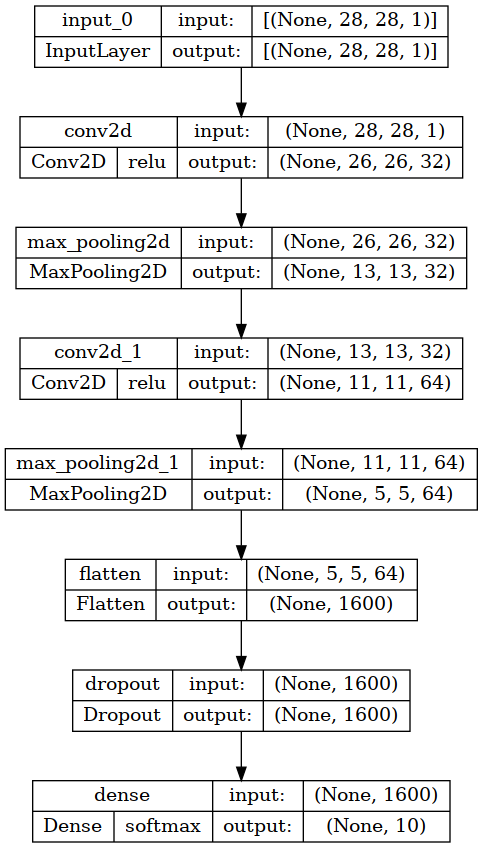

In [5]:
from tensorflow.keras.utils import plot_model

# plot model and display image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_activations=True)

## Train the model

In [6]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 5s 12ms/step - loss: 0.3640 - accuracy: 0.8909 - val_loss: 0.0841 - val_accuracy: 0.9772
Epoch 2/15
422/422 [==============================] - 5s 11ms/step - loss: 0.1124 - accuracy: 0.9665 - val_loss: 0.0585 - val_accuracy: 0.9858
Epoch 3/15
422/422 [==============================] - 5s 11ms/step - loss: 0.0845 - accuracy: 0.9745 - val_loss: 0.0485 - val_accuracy: 0.9865
Epoch 4/15
422/422 [==============================] - 5s 11ms/step - loss: 0.0697 - accuracy: 0.9784 - val_loss: 0.0432 - val_accuracy: 0.9882
Epoch 5/15
422/422 [==============================] - 5s 11ms/step - loss: 0.0626 - accuracy: 0.9805 - val_loss: 0.0391 - val_accuracy: 0.9882
Epoch 6/15
422/422 [==============================] - 5s 11ms/step - loss: 0.0540 - accuracy: 0.9827 - val_loss: 0.0351 - val_accuracy: 0.9902
Epoch 7/15
422/422 [==============================] - 5s 11ms/step - loss: 0.0501 - accuracy: 0.9841 - val_loss: 0.0365 - val_accuracy: 0.9908

## Evaluate the trained model

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.023600902408361435
Test accuracy: 0.9915000200271606


In [8]:
# iterate over the layers and export models from first to current layer to h5 files
for i in range(1, len(model.layers)):
    model_i = tf.keras.Model(inputs=model.inputs, outputs=model.layers[i].output, name=f"model_{i}")
    model_i.save(f"model_{i}/model.h5")
    # print(model_i.summary())

/home/cathie/miniconda3/envs/oppai/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
import tf2onnx

spec = tf.TensorSpec([1, 28, 28, 1], tf.float32, name="input_0")

for i in range(1, len(model.layers)):
    model_i = tf.keras.models.load_model(f'model_{i}/model.h5')
    tf2onnx.convert.from_keras(
        model_i,
        input_signature=[spec],
        inputs_as_nchw=['input_0'],
        opset=18,
        output_path=f'model_{i}/model.onnx'
    )

In [10]:
import sys
sys.path.append('..')
from keras2circom.keras2circom import circom, transpiler
circom.dir_parse('../keras2circom/node_modules/circomlib-ml/circuits/', skips=['util.circom', 'circomlib-matrix', 'circomlib', 'crypto'])

In [11]:
for i in range(1, len(model.layers)):
    args = {
        '<model.h5>': f'model_{i}/model.h5',
        '--output': f'model_{i}',
        '--raw': False,
        '--decimals': "18"
    }
    transpiler.transpile(args['<model.h5>'], args['--output'], args['--raw'], args['--decimals'])

In [14]:
import json

X = x_test[0]

input_json = {
    "in": [[[str(int(X[i][j][0] * float(10**18)))] for j in range(28)] for i in range(28)]
}

# write to circom_input.json
with open('circom_input.json', 'w') as f:
    json.dump(input_json, f)

In [16]:
input_json = {
    "input_data": [X.flatten().tolist()]
}

# write to ezkl_input.json
with open('ezkl_input.json', 'w') as f:
    json.dump(input_json, f)